In [1]:
from pyspark.sql import SparkSession

import pyspark.sql.functions as spf

from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

ModuleNotFoundError: No module named 'pyspark'

In [2]:
spark = SparkSession.builder.appName("anokhin").getOrCreate()
spark

## Model Based Collaborative filtering

### Собираем данные на Spark и сохраняем как pandas dataframe

In [13]:
data = (
    spark.read.json("/user/anokhin/seminar-2/*/data.json")
#         .filter(spf.col("time") > 0.8)
        .select("user", "track", "time")
        .groupBy("user", "track")
        .agg(
            spf.avg("time").alias("time")
        )
        .withColumn("test", spf.rand() > 0.8)
)

data.limit(10).show()

+----+-----+------------------+-----+
|user|track|              time| test|
+----+-----+------------------+-----+
|8779| 9293|               1.0|false|
|5021|46804|0.6666666666666666|false|
|6980|40897|             0.045| true|
|8406|24479|              0.61|false|
|2374| 3146|               0.0|false|
|2319|22543|              0.37|false|
|8377|45742|              0.02|false|
|1249|16019|              0.01|false|
|7604| 6823|              0.13|false|
|5287| 2803|               0.4| true|
+----+-----+------------------+-----+



In [14]:
data.toPandas().to_json("/home/anokhin/week04.json", orient="records", lines=True)

### Обучаем ALS на Spark и сохраняем рекомендации

In [15]:
als = ALS(
    rank=50,
    maxIter=25, 
    regParam=0.1, 
    userCol="user", 
    itemCol="track", 
    ratingCol="time",
    coldStartStrategy="drop",
).fit(data.filter(spf.col("test") == False))

In [16]:
predictions = als.transform(data.filter(spf.col("test") == True))

predictions.show(10, False)

+----+-----+------------------+----+----------+
|user|track|time              |test|prediction|
+----+-----+------------------+----+----------+
|6958|471  |0.26              |true|0.31410235|
|2021|833  |0.3333333333333333|true|0.18633708|
|7045|1342 |0.5               |true|0.34375912|
|7833|1645 |0.53              |true|0.30532998|
|6676|1829 |0.5               |true|0.32647264|
|861 |1959 |0.3333333333333333|true|0.22080585|
|1290|1959 |0.2               |true|0.15932888|
|1323|2122 |0.0               |true|0.07266973|
|5733|2122 |1.0               |true|0.5562232 |
|1235|2142 |0.0               |true|0.17401683|
+----+-----+------------------+----+----------+
only showing top 10 rows



In [17]:
evaluator = RegressionEvaluator(
    metricName="rmse", 
    labelCol="time",
    predictionCol="prediction"
)

rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.2518213382053526


In [19]:
(
    als
        .recommendForAllUsers(100)
        .select(
            spf.col("user"),
            spf.col("recommendations.track").alias("tracks")
        )
).toPandas().to_json("/home/anokhin/recomendations_als.json", orient="records", lines=True)

### Train LightFM

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import scipy.special as sp

import lightfm
import lightfm.data as ld
import lightfm.evaluation as lv

import tqdm
import json
import optuna

import tensorboardX as tb

import matplotlib.pyplot as pl
import seaborn as sns

np.random.seed(31337)

/Users/n.anokhin/Projects/virtualenv/recsys-course/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [12]:
full_data = pd.read_json("/Users/n.anokhin/Desktop/week04.json", lines=True)

data = full_data[full_data["time"] > 0.6]

data.head()

,user,track,time,test
0,6056,30982,1.00,False
3,7023,18160,0.80,False
7,7886,41089,1.00,False
9,6773,16468,1.00,True
14,7516,9555,0.64,True


In [17]:
user_counts = data.loc[~data["test"], "user"].value_counts()
users = set(user_counts[user_counts >= 3].index.values)

len(users)

9270

In [18]:
track_counts = data.loc[~data["test"], "track"].value_counts()
tracks = set(track_counts[track_counts >= 5].index.values)

len(tracks)

3327

In [19]:
train_data = data[~data["test"] & data["user"].isin(users) & data["track"].isin(tracks)]
test_data = full_data[full_data["test"] & full_data["user"].isin(users) & full_data["track"].isin(tracks)]

len(train_data), len(test_data)

(20361, 6130)

In [20]:
dataset = ld.Dataset()
dataset.fit(users, tracks)

In [21]:
train_interactions, _ = dataset.build_interactions(train_data[["user", "track"]].itertuples(index=False, name=None))
test_interactions, _ = dataset.build_interactions(test_data[["user", "track"]].itertuples(index=False, name=None))

In [23]:
def fit_model(epochs=1, at=10, loss="warp", no_components=30, learning_rate=0.01, max_sampled=10, user_alpha=0.0, item_alpha=0.0, threads=30, verbose=False):
    model = lightfm.LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=user_alpha,
    )

    precisions_at = []
    for epoch in range(epochs):
        model = model.fit_partial(train_interactions, num_threads=threads)
        precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=at, num_threads=threads)
        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
        precisions_at.append(np.mean(precision_at))
            
    return model, precisions_at


def objective(trial):
    loss = trial.suggest_categorical("loss", ["warp", "bpr"])
    no_components = trial.suggest_categorical("no_components", [10, 30, 50])
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.001, 0.01])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.001, 0.01])
    
    model, precisions_at = fit_model(
        epochs=3, 
        at=10,
        loss=loss,
        no_components=no_components, 
        learning_rate=learning_rate, 
        max_sampled=max_sampled, 
        user_alpha=user_alpha, 
        item_alpha=item_alpha,
    )
    
    return precisions_at[-1]

In [25]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
best_params = study.best_params

best_params

[I 2024-10-10 15:52:58,991] A new study created in memory with name: no-name-b75548e2-9973-4af4-ba0d-ee6eae7b4d8d
[I 2024-10-10 15:53:01,010] Trial 0 finished with value: 0.0008789062267169356 and parameters: {'loss': 'warp', 'no_components': 50, 'learning_rate': 0.001, 'max_sampled': 100, 'user_alpha': 0.001, 'item_alpha': 0.01}. Best is trial 0 with value: 0.0008789062267169356.
[I 2024-10-10 15:53:03,192] Trial 1 finished with value: 0.0010009766556322575 and parameters: {'loss': 'warp', 'no_components': 50, 'learning_rate': 0.01, 'max_sampled': 100, 'user_alpha': 0.001, 'item_alpha': 0.0}. Best is trial 1 with value: 0.0010009766556322575.
[I 2024-10-10 15:53:04,886] Trial 2 finished with value: 0.0011962892021983862 and parameters: {'loss': 'warp', 'no_components': 10, 'learning_rate': 0.01, 'max_sampled': 50, 'user_alpha': 0.001, 'item_alpha': 0.01}. Best is trial 2 with value: 0.0011962892021983862.
[I 2024-10-10 15:53:06,516] Trial 3 finished with value: 0.0013183595146983862 a

{'loss': 'warp',
 'no_components': 10,
 'learning_rate': 0.01,
 'max_sampled': 20,
 'user_alpha': 0.0,
 'item_alpha': 0.001}

In [26]:
best_params = {
    'loss': 'warp',
    'no_components': 50,
    'learning_rate': 0.01,
    'max_sampled': 100,
    'user_alpha': 0.0,
    'item_alpha': 0.001
}

In [27]:
model, precisions_at = fit_model(
    epochs=100,
    at=10,
    loss=best_params["loss"],
    no_components=best_params["no_components"], 
    learning_rate=best_params["learning_rate"], 
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    verbose=True,
)

0:	0.0007812499534338713 +/- 0.00026966277218889447
1:	0.0009521485189907253 +/- 0.0002974431030452251
2:	0.0009277343633584678 +/- 0.0002936412103008479
3:	0.0009277344215661287 +/- 0.0002936412103008479
4:	0.0011718750465661287 +/- 0.00032961740973405537
5:	0.0012451172806322575 +/- 0.0003463137021753937
6:	0.0014160156715661287 +/- 0.0003743254014989361
7:	0.0017822266090661287 +/- 0.000427243608282879
8:	0.002368164248764515 +/- 0.0004943530703894794
9:	0.0029296875 +/- 0.0005672352213878185
10:	0.003588867373764515 +/- 0.0006271408870816231
11:	0.004321289248764515 +/- 0.0006858007225673645
12:	0.00510253943502903 +/- 0.000754169134888798
13:	0.0057373046875 +/- 0.0008001170528586953
14:	0.006640625186264515 +/- 0.0008560156973544508
15:	0.00766601599752903 +/- 0.0009229516901541501
16:	0.00861816480755806 +/- 0.000974433512892574
17:	0.00966796837747097 +/- 0.0010394148528575897
18:	0.010791015811264515 +/- 0.0011082928348332642
19:	0.012133789248764515 +/- 0.00115721448790282
20

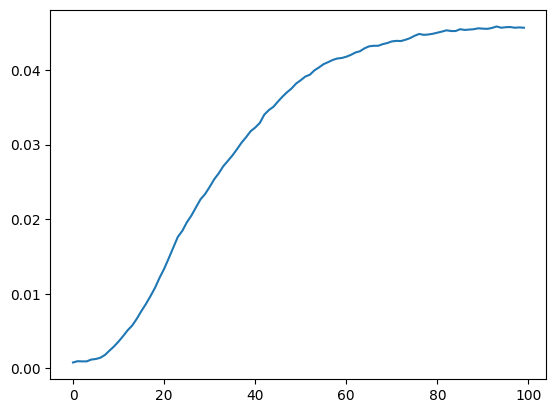

In [28]:
figure, ax = pl.subplots()

ax.plot(np.arange(len(precisions_at)), precisions_at)

pass

In [29]:
predictions = model.predict(
    test_data["user"].map(dataset.mapping()[0]).values,
    test_data["track"].map(dataset.mapping()[2]).values,
)

rmse = np.sqrt(((predictions - test_data["time"].values) * (predictions - test_data["time"].values)).mean())
rmse # Q: ???

0.7242846755086635

## Save track embeddings

In [30]:
BOTIFY_DATA_DIR = "/Users/n.anokhin/Projects/recsys-course/botify/data/"

In [31]:
biases, embeddings = model.get_item_representations()

In [32]:
track_meta = pd.read_json(BOTIFY_DATA_DIR + "tracks.json", lines=True)
track_meta["dataset_index"] = track_meta["track"].map(lambda t: dataset.mapping()[2].get(t))

In [33]:
dataset_tracks = track_meta[pd.notnull(track_meta["dataset_index"])].sort_values("dataset_index")

In [34]:
writer = tb.SummaryWriter(comment='msd_ligtfm_embeddings', log_dir="/Users/n.anokhin/Desktop/tb")
writer.add_embedding(embeddings, metadata=list(dataset_tracks[["artist", "title"]].itertuples(index=False, name=None)), tag="lightfm", metadata_header=["artist", "title"])
writer.close()

## Compute top recommendations

In [35]:
tracks = dataset_tracks["track"].values
users = [user for user, index in sorted(dataset.mapping()[0].items(), key=lambda kv: kv[1])]

In [36]:
predictions = model.predict(1, np.arange(dataset.item_features_shape()[0]), num_threads=30)
predictions

array([-0.78103983, -0.54207706, -0.74053866, ..., -0.09067989,
       -0.6363414 , -0.57208824], dtype=float32)

In [37]:
with open(BOTIFY_DATA_DIR + "recommendations_lfm.json", "w") as rf:
    for user_index in tqdm.tqdm(range(dataset.user_features_shape()[0])):
        predictions = model.predict(user_index, np.arange(dataset.item_features_shape()[0]), num_threads=30)
        top = tracks[np.argsort(predictions)[-100:]]
        recommendation = {
            "user": int(users[user_index]),
            "tracks": top.tolist()
        }
        rf.write(json.dumps(recommendation) + "\n")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9270/9270 [00:06<00:00, 1443.81it/s]
